In [9]:
import numpy as np
import pandas as pd
import seaborn as sns
from transformers import AutoTokenizer
import matplotlib.pyplot as plt

from mechir.data import CatDataCollator, DotDataCollator, MechDataset

def process_frame(frame):

    output = {
        'qid': [],
        'query': [],
        'docno': [],
        'text': [],
        'perturbed': [],
    }

    for row in frame.itertuples():
        output['qid'].append(row.qid)
        output['query'].append(row.query)
        output['docno'].append(row.docno)
        output['text'].append(row.text)
        output['perturbed'].append(row.perturbed_text)
    
    return pd.DataFrame(output)

In [10]:
tokenizer = AutoTokenizer.from_pretrained('sebastian-hofstaetter/distilbert-dot-tas_b-b256-msmarco')

data_path = '/mnt/qb/work/eickhoff/esx208/MechIR/data/patching/sebastian-hofstaetter-distilbert-dot-tas_b-b256-msmarco_bi_STMC1_4000_batch_size_100_patch_head.npy'

data = np.load(data_path)
queries = np.load(data_path.replace("patch_head", "queries"))
documents = np.load(data_path.replace("patch_head", "documents"))

queries = queries.reshape(-1, queries.shape[-1])
documents = documents.reshape(-1, documents.shape[-1])

/scratch_local/esx208-1051587/ir_mech_interp/lib/python3.9/site-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


Let's try to sort all patching effects by the magnitude

In [11]:
mean_magnitude = np.mean(np.abs(data), axis=(-2,-1))
sorted_magnitudes = np.argsort(mean_magnitude)[::-1]
sorted_data = data[sorted_magnitudes]

<Axes: >

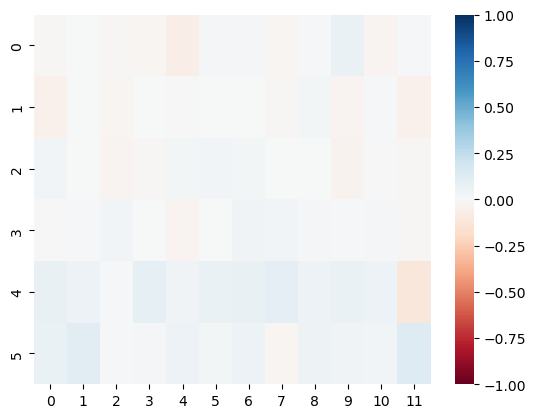

In [12]:
sns.heatmap(
        np.mean(data, axis=0),
        vmin=-1,
        vmax=1,
        cmap='RdBu',)

<Axes: >

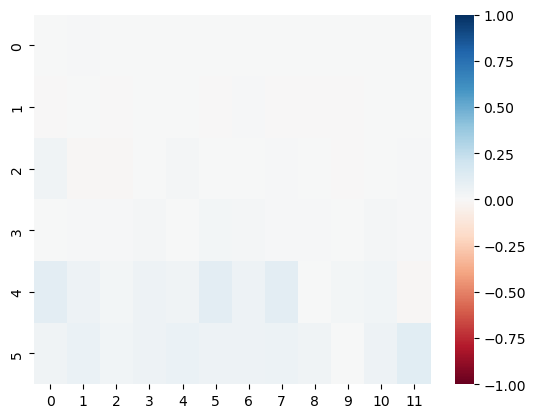

In [13]:
sns.heatmap(
        np.mean(data[:1000], axis=0),
        vmin=-1,
        vmax=1,
        cmap='RdBu',)

<Axes: >

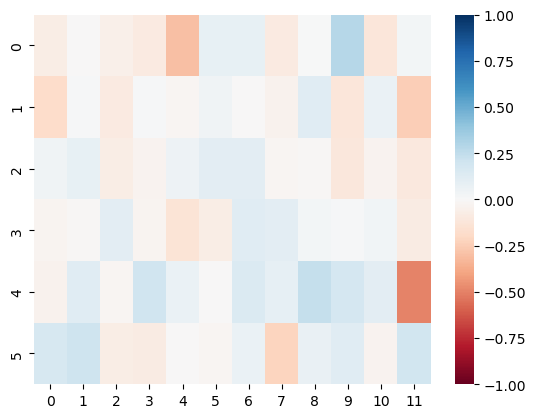

In [14]:
sns.heatmap(
        np.mean(sorted_data[:1000], axis=0),
        vmin=-1,
        vmax=1,
        cmap='RdBu',)

<Axes: >

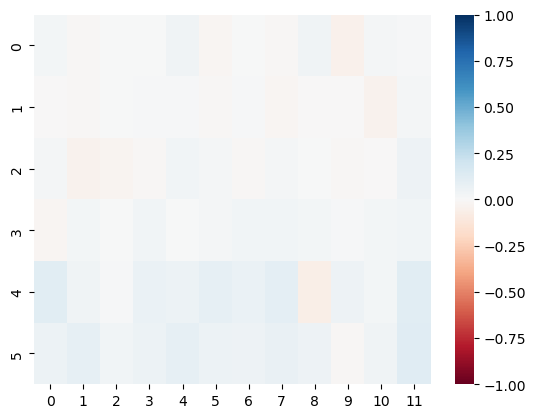

In [15]:
sns.heatmap(
        np.mean(sorted_data[100:1000], axis=0),
        vmin=-1,
        vmax=1,
        cmap='RdBu',)

<Axes: >

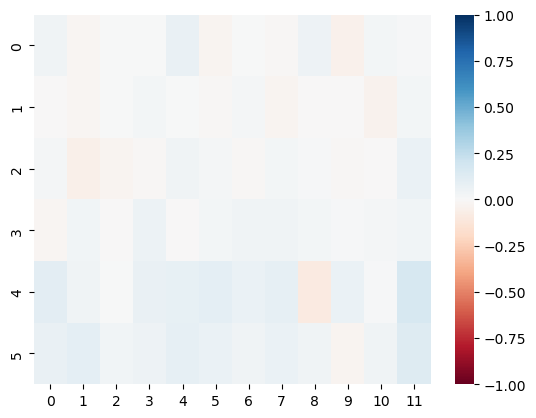

In [16]:
sns.heatmap(
        np.mean(sorted_data[100:500], axis=0),
        vmin=-1,
        vmax=1,
        cmap='RdBu',)

Let's try to extract some features from the dataset and test whether there will be a correlation between these features and the patching effect

In [17]:
def load_data(data_path):
    data = np.load(data_path)
    queries = np.load(data_path.replace("patch_head", "queries"))
    documents = np.load(data_path.replace("patch_head", "documents"))
    
    if len(queries.shape) == 3:
        queries = queries.reshape(-1, queries.shape[-1])
        documents = documents.reshape(-1, documents.shape[-1])
    
    return data, queries, documents

data_path = '/mnt/qb/work/eickhoff/esx208/MechIR/data/patching/sebastian-hofstaetter-distilbert-dot-tas_b-b256-msmarco_bi_STMC1_4000_batch_size_100_patch_head.npy'
data, queries, documents = load_data(data_path)

In [18]:
def plot_dependence(data, feature_x, feature_y='avg_patch_effect', ylim=[0,1]):
    plt.figure(figsize=(10, 6))
    sns.scatterplot(x=data[feature_x], y=data[feature_y])
    plt.ylim(ylim)
    plt.xlabel(feature_x)
    plt.ylabel(feature_y)
    plt.title(f'Dependence between {feature_x} and {feature_y}')
    plt.show()

In [19]:
FORMATTED_MODEL_NAME = 'sebastian-hofstaetter-distilbert-dot-tas_b-b256-msmarco'
MODEL_TYPE = 'bi'
PERTURBATION = 'STMC1'
K = 4000
in_file = f"./data/topk_my/{FORMATTED_MODEL_NAME}_{MODEL_TYPE}_{PERTURBATION}_topk_{K}.tsv"

all_data_pd = pd.read_csv(in_file, sep='\t')
# processed_frame = process_frame(all_data)
# dataset = MechDataset(processed_frame, pre_perturbed=True)

In [21]:
all_data_pd['avg_patch_effect'] = np.mean(np.abs(data), axis=(-2,-1))
all_data_pd['avg_patch_effect_selected_heads'] = np.mean(np.abs(data)[:, [0,1,2], [9,6,3]], axis=-1)
all_data_pd['tokenized_query_length'] = all_data_pd['query'].apply(lambda x: len(tokenizer(x)['input_ids']))
all_data_pd['tokenized_doc_length'] = all_data_pd['text'].apply(lambda x: len(tokenizer(x)['input_ids']))
all_data_pd['selected_term_exists'] = all_data_pd.apply(lambda row: row['inj_term'] in row['text'].lower(), axis=1)
all_data_pd['injected_synonym_exists'] = all_data_pd.apply(lambda row: row['synonym'] in row['text'].lower(), axis=1)

Correlation between score delta and patching effect

In [22]:
target_property = 'score_delta'

In [23]:
all_data_pd[target_property].corr(all_data_pd['avg_patch_effect'], method='pearson')

-0.04585845823653753

In [24]:
all_data_pd[target_property].corr(all_data_pd['avg_patch_effect'], method='spearman')

-0.7847146834557783

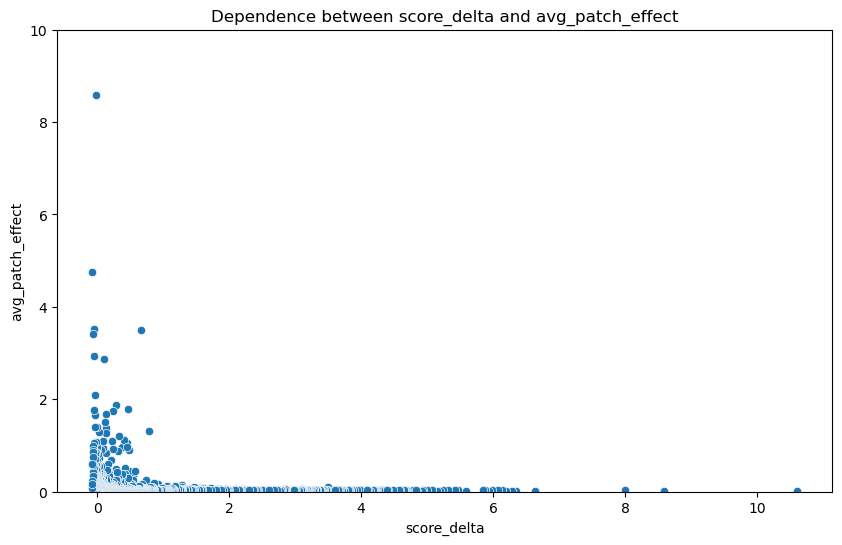

In [25]:
plot_dependence(all_data_pd, 'score_delta', 'avg_patch_effect', ylim=[0,10])

Correlation between relevance and patching effect

In [26]:
target_property = 'relevance'

In [27]:
all_data_pd[target_property].corr(all_data_pd['avg_patch_effect'], method='pearson')

0.056827126871452915

In [28]:
all_data_pd[target_property].corr(all_data_pd['avg_patch_effect'], method='spearman')

0.5898185889662615

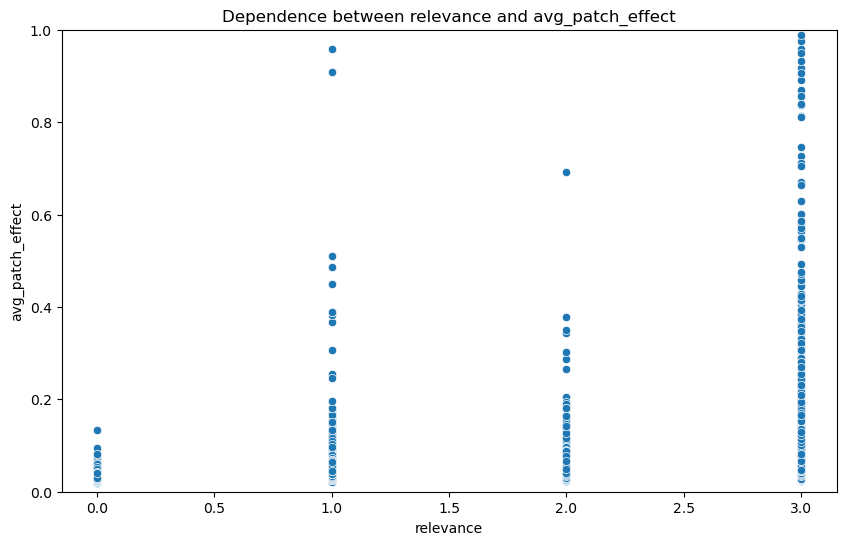

In [29]:
plot_dependence(all_data_pd, 'relevance', 'avg_patch_effect')

Document length

In [30]:
target_property = 'tokenized_doc_length'

In [31]:
all_data_pd[target_property].corr(all_data_pd['avg_patch_effect'], method='pearson')

-0.00501213106226432

In [32]:
all_data_pd[target_property].corr(all_data_pd['avg_patch_effect'], method='spearman')

0.1312091061737841

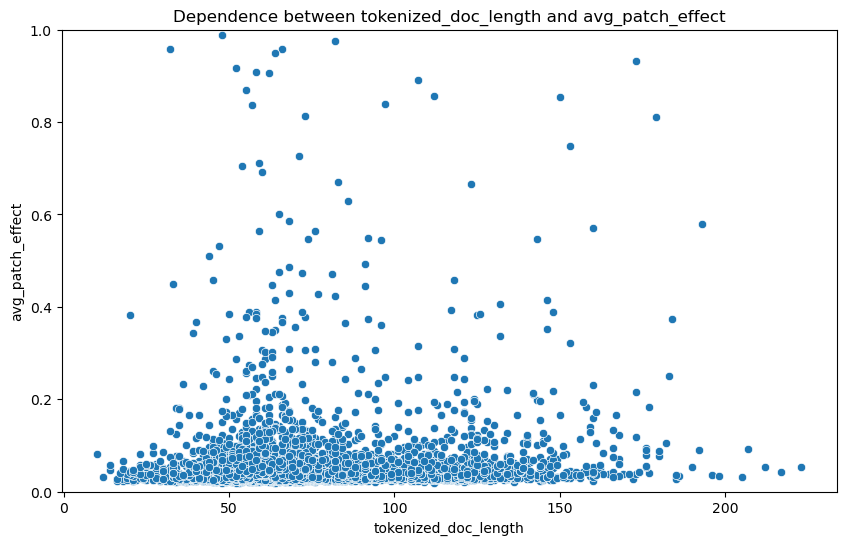

In [33]:
plot_dependence(all_data_pd, 'tokenized_doc_length', 'avg_patch_effect')

Query length

In [34]:
target_property = 'tokenized_query_length'

In [35]:
all_data_pd[target_property].corr(all_data_pd['avg_patch_effect'], method='pearson')

0.0008514362141035697

In [36]:
all_data_pd[target_property].corr(all_data_pd['avg_patch_effect'], method='spearman')

0.06696947540270845

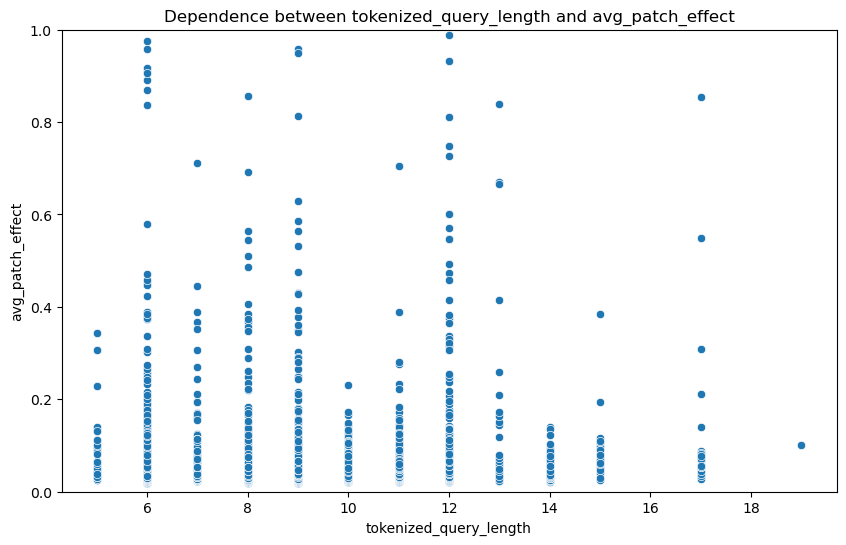

In [37]:
plot_dependence(all_data_pd, 'tokenized_query_length', 'avg_patch_effect')

Original score

In [38]:
target_property = 'original_score'

In [39]:
all_data_pd[target_property].corr(all_data_pd['avg_patch_effect'], method='pearson')

0.03489531560177154

In [40]:
all_data_pd[target_property].corr(all_data_pd['avg_patch_effect'], method='spearman')

0.42183362392779705

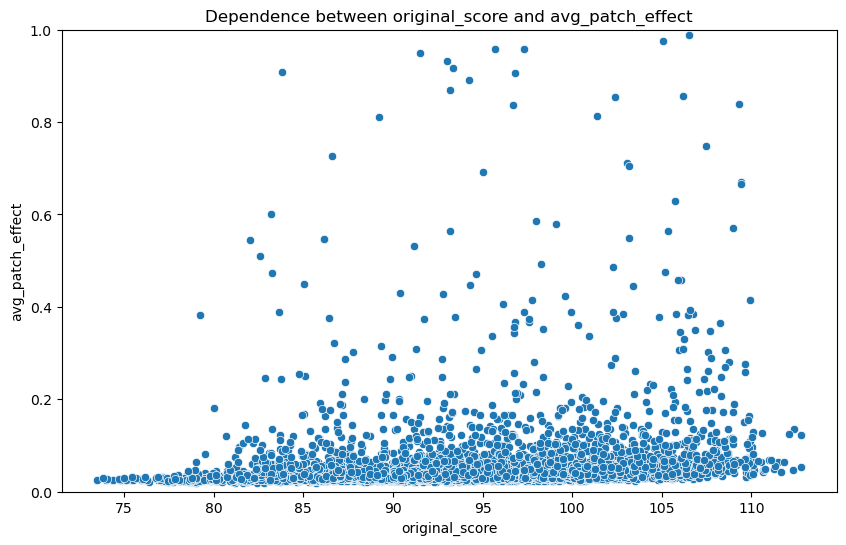

In [41]:
plot_dependence(all_data_pd, 'original_score', 'avg_patch_effect')

Perturbed score

In [42]:
target_property = 'perturbed_score'

In [43]:
all_data_pd[target_property].corr(all_data_pd['avg_patch_effect'], method='pearson')

0.031042934804218856

In [44]:
all_data_pd[target_property].corr(all_data_pd['avg_patch_effect'], method='spearman')

0.36245006234547655

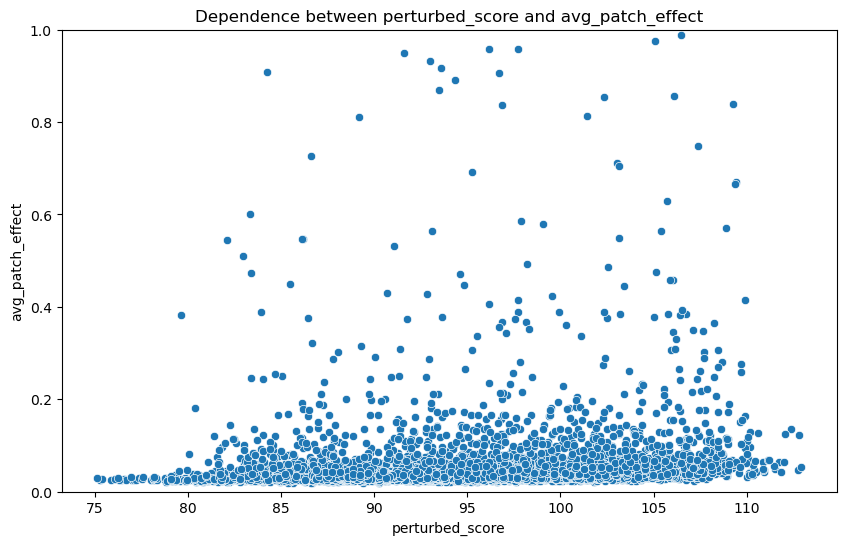

In [45]:
plot_dependence(all_data_pd, 'perturbed_score', 'avg_patch_effect')

Existence of the appended synonym in the document

In [46]:
target_property = 'injected_synonym_exists'

In [47]:
all_data_pd[target_property].corr(all_data_pd['avg_patch_effect'], method='pearson')

0.03350319066989902

In [48]:
all_data_pd[target_property].corr(all_data_pd['avg_patch_effect'], method='spearman')

0.22032587119650954

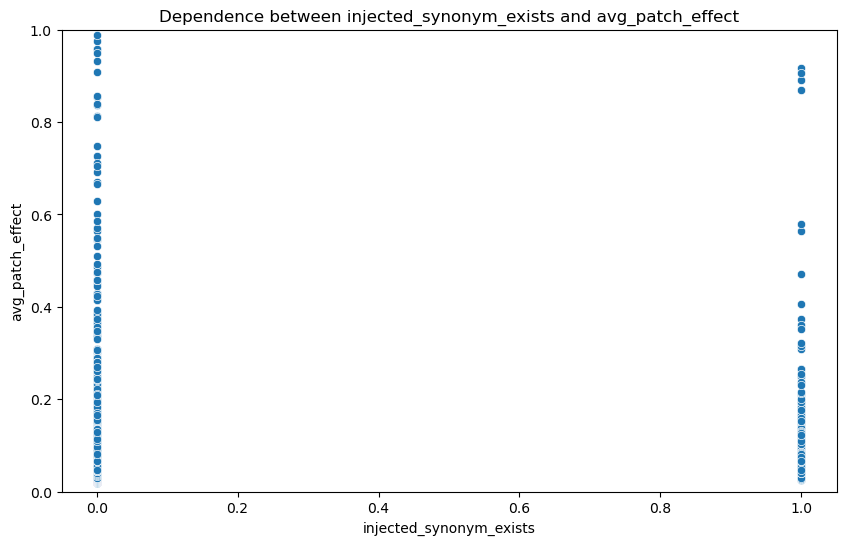

In [50]:
plot_dependence(all_data_pd, 'injected_synonym_exists', 'avg_patch_effect')

Existence of the original term from the query (for which the synonym was generated)

In [51]:
target_property = 'selected_term_exists'

In [52]:
all_data_pd[target_property].corr(all_data_pd['avg_patch_effect'], method='pearson')

0.03456371600127976

In [53]:
all_data_pd[target_property].corr(all_data_pd['avg_patch_effect'], method='spearman')

0.3950839958573697

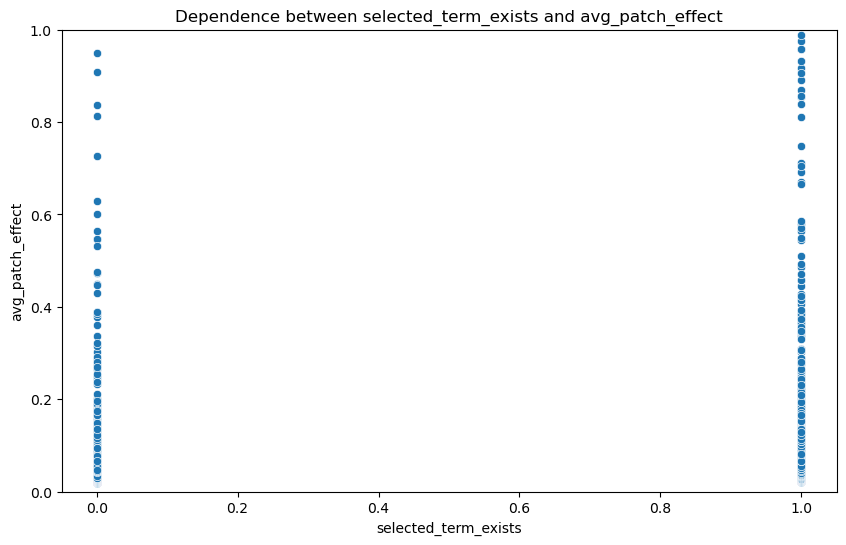

In [54]:
plot_dependence(all_data_pd, 'selected_term_exists', 'avg_patch_effect')

Combine all the results into a single table

In [55]:
target_properties = ['score_delta', 'relevance', 'tokenized_doc_length', 'tokenized_query_length', 'original_score',
                     'perturbed_score', 'injected_synonym_exists', 'selected_term_exists']
correlation_data = [{'target property': target_property, 
                     'average absolute patching effect': all_data_pd[target_property].corr(all_data_pd['avg_patch_effect'], method='spearman')} 
                    for target_property in target_properties]

In [57]:
pd.DataFrame(correlation_data)

,target property,average absolute patching effect
0,score_delta,-0.784715
1,relevance,0.589819
2,tokenized_doc_length,0.131209
3,tokenized_query_length,0.066969
4,original_score,0.421834
5,perturbed_score,0.362450
6,injected_synonym_exists,0.220326
7,selected_term_exists,0.395084


Let's try to multiply patching effect and score difference and sort them so that we could get queries and document with both high patching effect and score difference

In [44]:
all_data_pd['patched_effect_score_diff_mult'] = all_data_pd['score_delta'] * all_data_pd['avg_patch_effect']

In [45]:
all_data_pd.sort_values(by='patched_effect_score_diff_mult', ascending=False)[['query', 'text', 'perturbed_text', 'score_delta', 'avg_patch_effect', 'patched_effect_score_diff_mult']]

,query,text,perturbed_text,score_delta,avg_patch_effect,patched_effect_score_diff_mult
2610,ia suffix meaning,"Insomnia, also known as sleeplessness, is a sl...","Insomnia, also known as sleeplessness, is a sl...",0.313210,23.177811,7.259511
3744,what is durable medical equipment consist of,Medicare generally covers Durable Medical Equi...,Medicare generally covers Durable Medical Equi...,0.040268,88.071259,3.546449
2267,definition of laudable,One of Emma's less laudable characteristics wa...,One of Emma's less laudable characteristics wa...,0.655792,3.488909,2.288000
1266,what is durable medical equipment consist of,Medical supplies and equipments near you. Find...,Medical supplies and equipments near you. Find...,0.777878,1.304391,1.014657
1589,does legionella pneumophila cause pneumonia,legend drug; Legendre; Legendre sign; Legendre...,legend drug; Legendre; Legendre sign; Legendre...,0.468796,1.783231,0.835971
...,...,...,...,...,...,...
3945,what the best way to get clothes white,Even if you carefully follow all the rules on ...,Even if you carefully follow all the rules on ...,-0.050316,3.508476,-0.176532
3983,what types of food can you cook sous vide,This means that the fruit is cooked but still ...,This means that the fruit is cooked but still ...,-0.069611,3.411415,-0.237471
3993,exons definition biology,"Such stretches of DNA, which get transcribed i...","Such stretches of DNA, which get transcribed i...",-0.074646,4.750135,-0.354579
3961,difference between a hotel and motel,Re: What's the difference between lodges /hote...,Re: What's the difference between lodges /hote...,-0.056488,12.524331,-0.707475


In [46]:
all_data_pd['patched_effect_score_diff_harmonic_mean'] = 2 / (1/all_data_pd['score_delta'] + 1/all_data_pd['avg_patch_effect'])

In [47]:
all_data_pd.sort_values(by='patched_effect_score_diff_harmonic_mean', ascending=False)[['query', 'text', 'perturbed_text', 'score_delta', 'avg_patch_effect', 'patched_effect_score_diff_harmonic_mean']]

,query,text,perturbed_text,score_delta,avg_patch_effect,patched_effect_score_diff_harmonic_mean
3982,does legionella pneumophila cause pneumonia,Atypical organisms such as Mycoplasma pneumoni...,Atypical organisms such as Mycoplasma pneumoni...,-0.069321,0.066681,3.502784
2267,definition of laudable,One of Emma's less laudable characteristics wa...,One of Emma's less laudable characteristics wa...,0.655792,3.488909,1.104060
3995,medicare's definition of mechanical ventilation,CPAP is the abbreviation for continuous positi...,CPAP is the abbreviation for continuous positi...,-0.075050,0.065692,1.053688
1266,what is durable medical equipment consist of,Medical supplies and equipments near you. Find...,Medical supplies and equipments near you. Find...,0.777878,1.304391,0.974568
1589,does legionella pneumophila cause pneumonia,legend drug; Legendre; Legendre sign; Legendre...,legend drug; Legendre; Legendre sign; Legendre...,0.468796,1.783231,0.742417
...,...,...,...,...,...,...
3987,exons definition biology,"For other uses, see Exon (disambiguation) . An...","For other uses, see Exon (disambiguation) . An...",-0.071716,0.122725,-0.345093
3990,where is the show shameless filmed,(See Shameless UK TV Series). The show first a...,(See Shameless UK TV Series). The show first a...,-0.073967,0.128494,-0.348609
3952,medicare's definition of mechanical ventilation,BiPAP (also referred to as BPAP) stands for Bi...,BiPAP (also referred to as BPAP) stands for Bi...,-0.053558,0.066208,-0.560641
3939,how long is life cycle of flea,1 Fleas pass through a complete life cycle of ...,1 Fleas pass through a complete life cycle of ...,-0.049347,0.054616,-1.022945


In [213]:
sorted_harmonic_mean = all_data_pd.sort_values(by='patched_effect_score_diff_harmonic_mean', ascending=False)[['query', 'text', 'perturbed_text', 'inj_term', 'synonym', 'score_delta', 'injected_term_exists', 'avg_patch_effect', 'patched_effect_score_diff_harmonic_mean']].index.values

<Axes: >

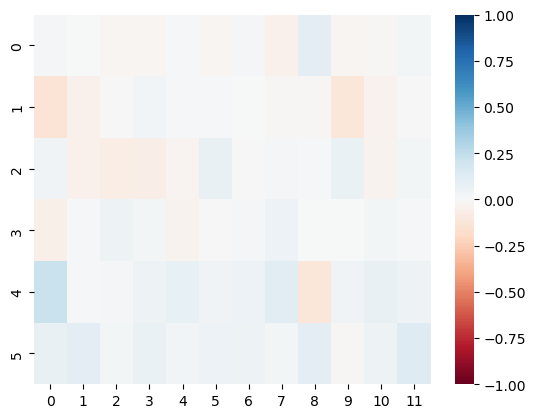

In [214]:
sns.heatmap(
        np.mean(data[sorted_harmonic_mean[:1000]], axis=0),
        vmin=-1,
        vmax=1,
        cmap='RdBu',)

In [76]:
data[]

array([[[ 2.70723854e-03,  4.69205342e-03,  2.48297793e-03, ...,
          6.53186089e-06,  5.35830297e-03,  1.69654191e-03],
        [ 9.28917713e-03,  9.85962618e-03, -1.52105268e-03, ...,
          8.46616272e-03,  2.76210625e-03, -1.02550210e-03],
        [ 5.77372918e-03, -3.53722018e-03, -2.88882433e-03, ...,
         -3.14617949e-03,  6.69254456e-03,  2.18556053e-03],
        [ 4.39289398e-03,  9.48861649e-04,  8.12955387e-03, ...,
          5.48676289e-05,  2.36035325e-02,  7.54830539e-02],
        [ 8.02012309e-02,  7.10831881e-02,  6.08869568e-02, ...,
          1.10407606e-01,  8.60246085e-03,  7.22859229e-04],
        [ 4.88282703e-02,  7.55518535e-03,  1.96652557e-03, ...,
         -6.63593505e-03,  1.42150708e-02,  2.30182763e-02]],

       [[ 1.70010945e-03, -1.22443118e-04,  2.11016182e-03, ...,
          2.96065700e-03, -5.53108146e-03,  7.99403817e-04],
        [-5.02589345e-03,  1.94719795e-03, -9.67212545e-04, ...,
         -4.40134574e-03,  8.95420380e-04, -9.28013